# Document Clustering

The majority of financial reports have disclaimer sections in the end. It's a section aimed at
providing legal and regulatory information, often outlining the limitations and responsibilities
related to the content of the report.

Our objective is to establish a clear separation between the legal and financial content within a
document. This is imperative to avoid the risk of misleading analysis that could arise from
retaining both types of content.

Due to the absence of a labeled dataset generated from the reports for distinguishing between
financial and legal text, and subsequently training a supervised machine learning model for
content classification, we are considering an alternative approach. We are addressing this
challenge using unsupervised machine learning, specifically through clustering techniques.

### Installing & Importing required libraries

In [1]:
%%capture
!pip install wordninja
!pip install contractions
!pip install num2words 
!pip install textblob
!pip install gensim
!pip install joblib
!pip install hdbscan

In [2]:
import pandas as pd
import numpy as np
import re
import json
import os
import wordninja
from num2words import num2words
import contractions
from textblob import TextBlob
import gensim
import nltk
import joblib
from nltk import FreqDist
from nltk.stem.snowball import SnowballStemmer
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import string
nltk.download("punkt")
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_multiple_whitespaces
import warnings 
warnings.simplefilter("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Loading Data

In [3]:
report_name = "fx_insight_e_15_mai_2023"
report_path = f"/kaggle/input/4-document-embeddings/sent_embeddings/{report_name}.json"
with open(report_path, 'r') as json_file:
    report_data = json.load(json_file)

In [4]:
print('Report Name:', report_data['Report Name'])
print('Organization:', report_data['Bank Name'])
print('Date:', report_data['Report Date'])
print('Report Length:', len(report_data['Pages']), 'pages')

Report Name: fx_insight_e_15_mai_2023
Organization: citi
Date: 15-5-2023
Report Length: 7 pages


In [5]:
report_data.keys()

dict_keys(['Report Name', 'Bank Name', 'Report Date', 'Pages'])

In [6]:
report_data['Pages'][0].keys()

dict_keys(['Page ID', 'MSentences', 'HSentences', 'FinText', 'FinBert', 'GloVe'])

In [7]:
# Page 0, Sentence 0
report_data['Pages'][0]['MSentences'][0]

'invest product bank deposit'

## 2. Dimensionality Reduction


We currently possess complex embeddings representing document characteristics in a high-dimensional space. These are numerical representations of text documents, typically with 300 dimensions using techniques like GloVe or FinText. However, the high dimensionality can be computationally burdensome and hinder visualization and analysis. To address this, we'll use PCA and/or T-SNE to condense the embeddings while retaining crucial information. This enhances data visualization, and computation speed, unveiling hidden patterns, clusters, and relationships. We'll transform document embeddings into key components, potentially reducing dimensions to 2 or 3, all while preserving data distribution essence.

### 2.1. Using PCA

In [8]:
import numpy as np
from sklearn.decomposition import PCA

def perform_pca(embeddings, num_components=2):
    # Extract embeddings from the input and convert to a NumPy array
    embeddings_array = np.array([emb for _,_, emb in embeddings])
    
    # Apply PCA to reduce the dimensions to the specified number of components
    pca = PCA(n_components=num_components, random_state=42)
    reduced_embeddings = pca.fit_transform(embeddings_array)
    
    # Return the reduced embeddings along with the corresponding words/sentences
    reduced_embeddings_with_text = [(item[0], item[1], reduced_embeddings[i]) for i, item in enumerate(embeddings)]
    return reduced_embeddings_with_text


### 2.2. Using T-SNE

In [9]:
import numpy as np
from sklearn.manifold import TSNE

def perform_tsne(embeddings, num_components=2, perplexity=50, learning_rate=200):
    # Extract embeddings from the input and convert to a NumPy array
    embeddings_array = np.array([emb for _,_, emb in embeddings])
    
    # Apply t-SNE to reduce dimensions to the specified number of components
    tsne = TSNE(n_components=num_components, perplexity=perplexity, learning_rate=learning_rate, random_state=42, n_jobs=1)
    reduced_embeddings = tsne.fit_transform(embeddings_array)
    
    # Return the reduced embeddings along with the corresponding words/sentences
    reduced_embeddings_with_text = [(item[0], item[1], reduced_embeddings[i]) for i, item in enumerate(embeddings)]
    return reduced_embeddings_with_text


### 2.3 Using UMAP

In [10]:
import numpy as np
from umap import UMAP

def perform_umap(embeddings, num_components=2, n_neighbors=15, min_dist=0.1):
    # Extract embeddings from the input and convert to a NumPy array
    embeddings_array = np.array([emb for _, _, emb in embeddings])

    # Apply UMAP to reduce dimensions to the specified number of components
    umap = UMAP(n_components=num_components, n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
    reduced_embeddings = umap.fit_transform(embeddings_array)

    # Return the reduced embeddings along with the corresponding words/sentences
    reduced_embeddings_with_text = [(item[0], item[1], reduced_embeddings[i]) for i, item in enumerate(embeddings)]
    return reduced_embeddings_with_text


## 3. Document Clustering

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def perform_kmeans(embeddings, num_clusters=3, normalize=True):
    # Extract embeddings from the input and convert to a NumPy array
    embeddings_array = np.array([emb for _, _, emb in embeddings])
    
    if normalize:
        # Normalize the embeddings using StandardScaler
        scaler = StandardScaler()
        embeddings_array = scaler.fit_transform(embeddings_array)
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init="auto")
    cluster_labels = kmeans.fit_predict(embeddings_array)
    
    clusters_with_text = [(item[0], cluster_labels[i]) for i, item in enumerate(embeddings)]
    return clusters_with_text


import hdbscan

def perform_hdbscan(embeddings, min_cluster_size=20, min_samples=None):
    embeddings_array = np.array([emb for _, _, emb in embeddings])
    hdbscan_clustering = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    cluster_labels = hdbscan_clustering.fit_predict(embeddings_array)
    clusters_with_text = [(item[0], cluster_labels[i]) for i, item in enumerate(embeddings)]
    return clusters_with_text

In [12]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'notebook'

def visualize_clusters(reduced_embeddings, clusters, num_components, clustering_id="Clustering", labeled=-1):
    # Extract cluster labels, hover text, and original sentences from the input
    cluster_labels = [cluster for _, cluster in clusters]
    hover_text = [item[0] for item in reduced_embeddings]
    original_sentences = report_data['Pages'][labeled]['HSentences']
    
    # Create lists to store marker symbols and colors
    marker_symbols = []
    marker_colors = []

    # Iterate through hover_text and check if the sentence is in original_sentences
    for i, sentence in enumerate(hover_text):
        if sentence in original_sentences:
            marker_symbols.append("circle-open")  # Change marker shape for matching sentences
            marker_colors.append(cluster_labels[i]) # Change marker color for matching sentences
        else:
            marker_symbols.append("circle")  # Use default marker shape
            marker_colors.append(cluster_labels[i])  # Use cluster label color

    # Create a scatter plot using Plotly
    if num_components == 2:
        scatter = go.Scatter(
            x=[emb[0] for _, _, emb in reduced_embeddings],
            y=[emb[1] for _, _, emb in reduced_embeddings],
            mode='markers',
            text=hover_text,
            hoverinfo='text',
            marker=dict(symbol=marker_symbols, color=marker_colors, opacity=0.7)
        )
    elif num_components == 3:
        scatter = go.Scatter3d(
            x=[emb[0] for _, _, emb in reduced_embeddings],
            y=[emb[1] for _, _, emb in reduced_embeddings],
            z=[emb[2] for _, _, emb in reduced_embeddings],
            mode='markers',
            text=hover_text,
            hoverinfo='text',
            marker=dict(symbol=marker_symbols, color=marker_colors, opacity=0.7)
        )
    
    layout = go.Layout(
        title=clustering_id,
        scene=dict(
            xaxis_title="Dimension 1",
            yaxis_title="Dimension 2",
            zaxis_title="Dimension 3" if num_components == 3 else {}
        )
    )
    
    data = [scatter]
    fig = go.Figure(data=data, layout=layout)
    
    # Show the interactive plot
    fig.show()

In [13]:
def get_embeddings(document, model):
    data = []
    for i in range(len(document['Pages'])):
        hsentences, msentences, embeddings = document['Pages'][i]["HSentences"], document['Pages'][i]["MSentences"], document['Pages'][i][model]
        for j in range(len(hsentences)):
            if model == "FinBert":
                emb = embeddings[j][0]
            else:
                emb = embeddings[j]
            t = (hsentences[j], msentences[j], emb)
            data.append(t)
            
    return data

In [14]:
def cluster_document(document, model="GloVe", dim_reducer="pca", dimensions=2, clustering_algorithm="kmeans", num_clusters=5, clustering_params=None, normalize=False):
    sent_embeddings = get_embeddings(document, model)
    
    if dim_reducer == "pca":
        reduced_embeddings = perform_pca(sent_embeddings, num_components=dimensions)
    elif dim_reducer == "t-sne":
        reduced_embeddings = perform_tsne(sent_embeddings, num_components=dimensions, perplexity=10, learning_rate="auto")
    else: 
        reduced_embeddings = perform_umap(sent_embeddings, num_components=dimensions, n_neighbors=15, min_dist=0.1)
    
    if clustering_algorithm == "kmeans":
        clusters = perform_kmeans(reduced_embeddings, num_clusters=num_clusters, normalize=normalize)
    else:
        clusters = perform_hdbscan(reduced_embeddings, min_cluster_size=10, min_samples=None)
    clustering_id = str(dimensions) +"D Visualization of sentence-level " + clustering_algorithm.upper() + " clustering of " + dim_reducer.upper() + "-reduced "+ model.upper() + " embeddings"
    #elbow_figure(reduced_embeddings)
    
    return clustering_id, reduced_embeddings, clusters

In [15]:
import matplotlib.pyplot as plt
def elbow_figure(embeddings):
    distortions = []
    K_range = range(1, 20)  # Test clusters from 1 to 10
    embeddings_array = np.array([emb for _,_, emb in embeddings])
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(embeddings_array)
        distortions.append(kmeans.inertia_)
    # Plot the elbow curve
    plt.figure(figsize=(8, 6))
    plt.plot(K_range, distortions, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.xticks(K_range)
    plt.show()


### Clustering

In [16]:
embeddings_models = ['FinText', 'FinBert' ] #'GloVe'
reducers = ['umap', 't-sne', 'pca']
dimensions = [2,3]
clustering_algorithms = ['kmeans']

clustering = {}
for clustering_algorithm in clustering_algorithms:
    for embeddings_model in embeddings_models:
        for dim_reducer in reducers:
            for dimension in dimensions:
                clustering_id_1, reduced_embeddings_1, clusters_1 = cluster_document(report_data, model=embeddings_model, dim_reducer=dim_reducer, dimensions=dimension, clustering_algorithm=clustering_algorithm, num_clusters=2, clustering_params=None)
                clustering[clustering_id_1] = (reduced_embeddings_1, clusters_1)
                visualize_clusters(reduced_embeddings_1, clusters_1, num_components=dimension, clustering_id=clustering_id_1)

### Cluster Analysis

In [17]:
clustering_id = "3D Visualization of sentence-level KMEANS clustering of UMAP-reduced FINBERT embeddings"
clusters_x = clustering[clustering_id][1]

In [18]:
for i in range(2):
    sent = [text for text, cluster_id in clusters_x if cluster_id == i]
    print('Sentences within Cluster:')
    for s in sent[13:16]:
        print('*',s,'\n')

Sentences within Cluster:
* In any event, past performance is no guarantee of future results, and future results may not meet our expectations due to a variety of economic, market and other factors. 

* Further, any projections of potential risk or return are illustrative and should not be taken as limitations of the maximum possible loss or gain. 

* Investments are not deposits or other obligations of, guaranteed or insured by Citibank N.A., Citigroup Inc., or any of their affiliates or subsidiaries, or by any local government or insurance agency, and are subject to investment risk, including the possible loss of the principal amount invested. 

Sentences within Cluster:
* The improving outlook for Chinas economy, with stronger than expected credit expansion and trade data, points to government stimulus that may fuel investment. 

* On terms of trade, Citi analysts remain neutral iron ore and bullish copper in the medium term, both positive AUD drivers. 

* Combined with our EURUSD v

In [19]:
def remove_urls(text):
    url_pattern_1 = "^https?:\\/\\/(?:www\\.)?[-a-zA-Z0-9@:%._\\+~#=]{1,256}\\.[a-zA-Z0-9()]{1,6}\\b(?:[-a-zA-Z0-9()@:%_\\+.~#?&\\/=]*)$"
    url_pattern_2 = r'https?://\S+'
    url_pattern_3 = "^[-a-zA-Z0-9@:%._\\+~#=]{1,256}\\.[a-zA-Z0-9()]{1,6}\\b(?:[-a-zA-Z0-9()@:%_\\+.~#?&\\/=]*)$"
    url_pattern = f"({url_pattern_1})|({url_pattern_2})|({url_pattern_3})"
    text = re.sub(url_pattern, '', text, flags=re.MULTILINE)
    return text


def replace_symbols(text):
    symbols = {
        '$': 'dollar',
        '€': 'euro',
        '£': 'pound',
        '¥': 'yen',
        '₹': 'rupee',
        '%': 'percent'
    }
    
    for symbol, word in symbols.items():
        text = re.sub(r'(\d)' + re.escape(symbol), r'\1 ' + word, text)
        text = re.sub(re.escape(symbol) + r'(\d)', word + r' \1', text)
        text = re.sub(re.escape(symbol), word, text)
    return text

def clean_text(text):
    text = text.lower()
    text = remove_urls(text)
    text = contractions.fix(text)
    text = re.sub(r'[^\x00-\x7F$€£¥₹]+', '', text)
    text = replace_symbols(text)
    text = strip_punctuation(text)
    text = remove_stopwords(text)
    text = re.sub(r'[^a-z\s]', '', text)
    words = word_tokenize(text)
    reduced = [word for word in words if len(word) > 2]
    text = " ".join(reduced).strip()
    text = strip_multiple_whitespaces(text)
    return text

In [20]:
cluster_0 = clean_text(" ".join([text for text, cluster_id in clusters_x if cluster_id == 0]).strip())
cluster_1 = clean_text(" ".join([text for text, cluster_id in clusters_x if cluster_id == 1]).strip())

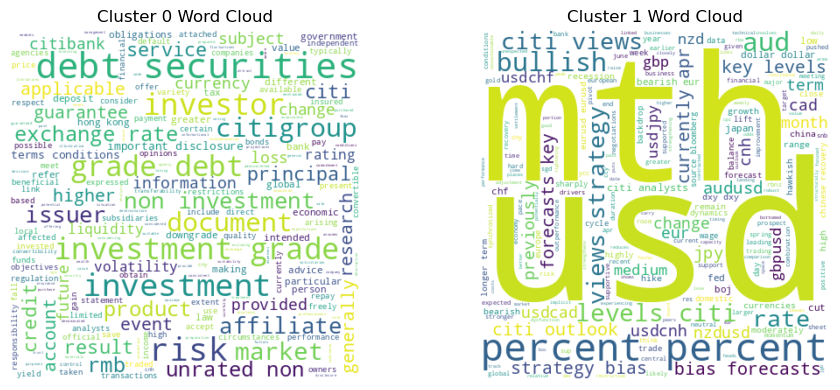

In [21]:
from wordcloud import WordCloud

def create_wordcloud(text, title):
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate(text)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)

# Create subplots for each cluster word cloud
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
create_wordcloud(cluster_0, "Cluster 0 Word Cloud")

plt.subplot(1, 2, 2)
create_wordcloud(cluster_1, "Cluster 1 Word Cloud")

plt.tight_layout()
plt.show()

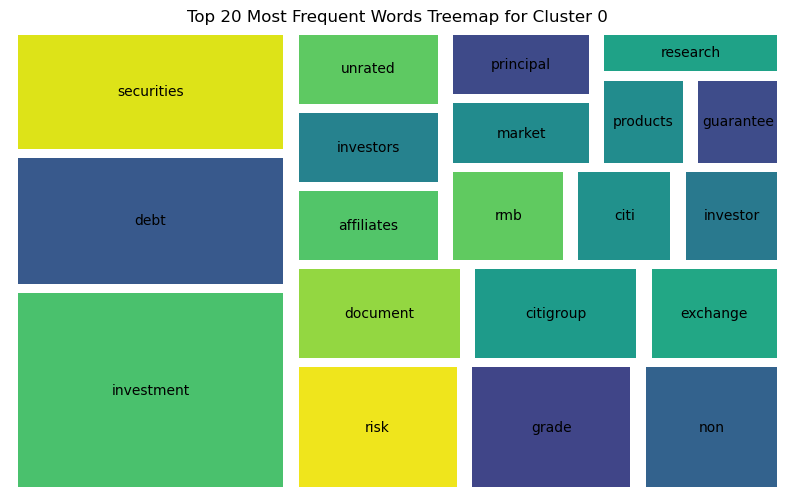

In [22]:
import matplotlib.pyplot as plt
import squarify
from collections import Counter

def plot_treemap(text, title):
    word_counts = Counter(text.split())
    top_words = word_counts.most_common(20)  # Display the top 10 most frequent words
    
    labels, counts = zip(*top_words)
    total_count = sum(counts)
    percentages = [(count / total_count) * 100 for count in counts]

    plt.figure(figsize=(10, 6))
    squarify.plot(sizes=percentages, label=labels, pad=True)
    plt.axis('off')
    plt.title(title)
    plt.show()


plot_treemap(cluster_0, "Top 20 Most Frequent Words Treemap for Cluster 0")


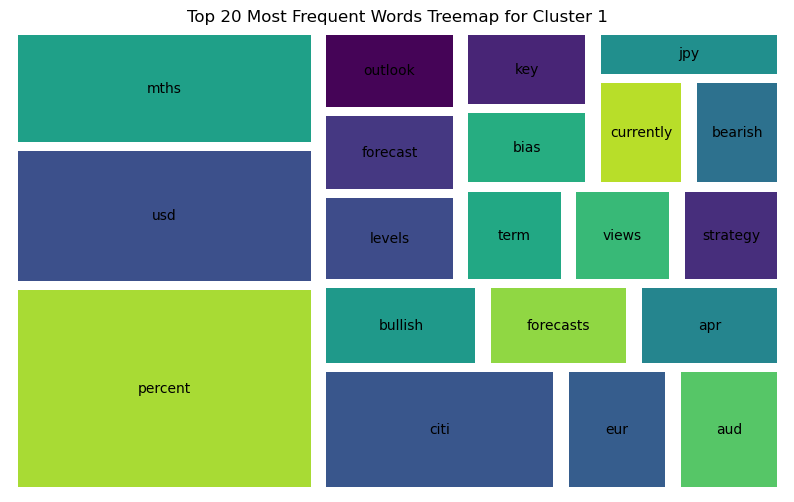

In [23]:
plot_treemap(cluster_1, "Top 20 Most Frequent Words Treemap for Cluster 1")

## 4. Financial vs Legal Text

In [24]:
folder_path = '/kaggle/input/4-document-embeddings/sent_embeddings' 

combined_pages = []

for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r') as json_file:
            data = json.load(json_file)
            pages = data.get('Pages', [])
            combined_pages.extend(pages)

print(len(combined_pages))

395


In [25]:
clustering_id_1, reduced_embeddings_1, clusters_1 = cluster_document({"Pages":combined_pages}, model="FinBert", dim_reducer="pca", dimensions=2, clustering_algorithm="kmeans", num_clusters=2, clustering_params=None, normalize=True)
visualize_clusters(reduced_embeddings_1, clusters_1, num_components=2, clustering_id=clustering_id_1, labeled=6)

In [26]:
data = []
for sentence, cluster_id in clusters_1:
    row = {}
    row['Text'] = sentence
    row['Label'] = cluster_id
    data.append(row)

In [27]:
df = pd.DataFrame(data)

In [28]:
# Financial
df[df['Label'] == 0].head(10)

Text  Label
0    Citi Global Wealth Investments FX Snapshot Ma...      0
4    Source: Bloomberg L.P. (K = Thousand, M = Mil...      0
5                          Sentiment Feb -- 66.4 66.4      0
16  In any event, past performance is no guarantee...      0
19  Investors investing in funds denominated in no...      0
36  Certain high-volatility investments can be sub...      0
37  Important Disclosure on High Yield Bonds Unrat...      0
38  As a result of being classified as non investm...      0
41  Many issuers of these Debt Securities have exp...      0
44  This lack of liquidity may make it more diffic...      0

In [29]:
# Legal
df[df['Label'] == 1].head(10)

Text  Label
1                             NOT GOVERNMENT INSURED.      1
2                                  NO BANK GUARANTEE.      1
3                    MAY LOSE VALUE February 20, 2023      1
6    Important Disclosure Citi analysts refers to ...      1
7                                       Citibank N.A.      1
8   and its affiliates / subsidiaries provide no i...      1
9   Investment products are not available to US pe...      1
10  This document is for general informational pur...      1
11  Save to the extent provided otherwise in the T...      1
12  Therefore, investment products mentioned in th...      1

In [30]:
df.to_csv('legal_financial.csv', index=False)